In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=428ae444dc92c69a3748dafd768f3c229c6ca1868b9e80d786194ba7b28fb011
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


#Introduction

This document presents an analysis of One-Day International (ODI) cricket data from 1971 to 2017 using PySpark, a powerful data processing framework in Python. The analysis aims to gain insights into various aspects of ODI matches.

#Data Preparation

Before diving into the analysis, it is crucial to prepare the data appropriately. This step involves cleaning the dataset by removing irrelevant or incomplete records, handling missing values, and ensuring data consistency.

In [42]:
#Importing necessary libraries
from pyspark import SparkContext, SQLContext, SparkConf, StorageLevel
from pyspark.sql import SparkSession

#Creating Spark session
spark = SparkSession.builder.appName("ODI").getOrCreate()
sc = spark.sparkContext

#Reading the input CSV file as a DataFrame named 'odi'
odi = spark.read.csv('originalDataset.csv', header=True)

In [43]:
#Displaying the contents of the DataFrame 'odi'
odi.show()

+---------+-----------+-----------+-----------+---------+------------+---------------+
|Scorecard|     Team 1|     Team 2|     Winner|   Margin|      Ground|     Match Date|
+---------+-----------+-----------+-----------+---------+------------+---------------+
|  ODI # 1|  Australia|    England|  Australia|5 wickets|   Melbourne|    Jan 5, 1971|
|  ODI # 2|    England|  Australia|    England|6 wickets|  Manchester|   Aug 24, 1972|
|  ODI # 3|    England|  Australia|  Australia|5 wickets|      Lord's|   Aug 26, 1972|
|  ODI # 4|    England|  Australia|    England|2 wickets|  Birmingham|   Aug 28, 1972|
|  ODI # 5|New Zealand|   Pakistan|New Zealand|  22 runs|Christchurch|   Feb 11, 1973|
|  ODI # 6|    England|New Zealand|    England|7 wickets|     Swansea|   Jul 18, 1973|
|  ODI # 7|    England|New Zealand|  no result|     null|  Manchester|   Jul 20, 1973|
|  ODI # 8|    England|West Indies|    England| 1 wicket|       Leeds|    Sep 5, 1973|
|  ODI # 9|    England|West Indies|West Ind

In [109]:
#Displaying the descriptive statistics of the DataFrame 'odi'
odi.describe().show()

+-------+---------+-----------+-----------+-----------+-------+---------+-----------+------------------+
|summary|Scorecard|     Team 1|     Team 2|     Winner| Margin|   Ground| Match Date|              year|
+-------+---------+-----------+-----------+-----------+-------+---------+-----------+------------------+
|  count|     3753|       3753|       3753|       3753|   3753|     3753|       3753|              3753|
|   mean|     null|       null|       null|       null|   null|     null|       null|2001.4796163069545|
| stddev|     null|       null|       null|       null|   null|     null|       null|10.145696234934519|
|    min|  ODI # 1|Afghanistan|Afghanistan|Afghanistan|  1 run| Aberdeen|Apr 1, 1984|              1971|
|    max|ODI # 999|   Zimbabwe|   Zimbabwe|   Zimbabwe|99 runs|Worcester|Sep 9, 2011|              2017|
+-------+---------+-----------+-----------+-----------+-------+---------+-----------+------------------+



In [6]:
# Get the column types of the DataFrame 'odi'
column_types = odi.dtypes

# Display the column types
for column_name, data_type in column_types:
    print("Column: {}, Data Type: {}".format(column_name,data_type))

Column: Scorecard, Data Type: string
Column: Team 1, Data Type: string
Column: Team 2, Data Type: string
Column: Winner, Data Type: string
Column: Margin, Data Type: string
Column: Ground, Data Type: string
Column: Match Date, Data Type: string


In [47]:
#Getting the count of rows in the DataFrame 'odi'
odi.count()

3753

In [45]:
from pyspark.sql.functions import col, isnan, isnull
from pyspark.sql.functions import col, sum

# Count the number of null values in each column
null_counts = odi.select([sum(col(c).isNull().cast("int")).alias(c) for c in odi.columns])
# Collect the results as a dictionary
null_counts_dict = null_counts.first().asDict()
# Print the null counts for each column
for column, count in null_counts_dict.items():
    print("Column '{}': {} null values".format(column, count))

Column 'Scorecard': 0 null values
Column 'Team 1': 0 null values
Column 'Team 2': 0 null values
Column 'Winner': 0 null values
Column 'Margin': 0 null values
Column 'Ground': 0 null values
Column 'Match Date': 0 null values


In [44]:
#Delete rows with null values in Margin column
odi = odi.na.drop(subset=['Margin'])

In [46]:
from pyspark.sql.functions import split, substring, col

# Extract the year column
odi = odi.withColumn("year", split(col("Match Date"), ",")[1].cast("int"))
odi.show()

+---------+-----------+-----------+-----------+---------+------------+---------------+----+
|Scorecard|     Team 1|     Team 2|     Winner|   Margin|      Ground|     Match Date|year|
+---------+-----------+-----------+-----------+---------+------------+---------------+----+
|  ODI # 1|  Australia|    England|  Australia|5 wickets|   Melbourne|    Jan 5, 1971|1971|
|  ODI # 2|    England|  Australia|    England|6 wickets|  Manchester|   Aug 24, 1972|1972|
|  ODI # 3|    England|  Australia|  Australia|5 wickets|      Lord's|   Aug 26, 1972|1972|
|  ODI # 4|    England|  Australia|    England|2 wickets|  Birmingham|   Aug 28, 1972|1972|
|  ODI # 5|New Zealand|   Pakistan|New Zealand|  22 runs|Christchurch|   Feb 11, 1973|1973|
|  ODI # 6|    England|New Zealand|    England|7 wickets|     Swansea|   Jul 18, 1973|1973|
|  ODI # 8|    England|West Indies|    England| 1 wicket|       Leeds|    Sep 5, 1973|1973|
|  ODI # 9|    England|West Indies|West Indies|8 wickets|    The Oval|    Sep 7,

#Exploratory Data Analysis (EDA)

Visualizing Winners: Bar Chart of Team Count

---



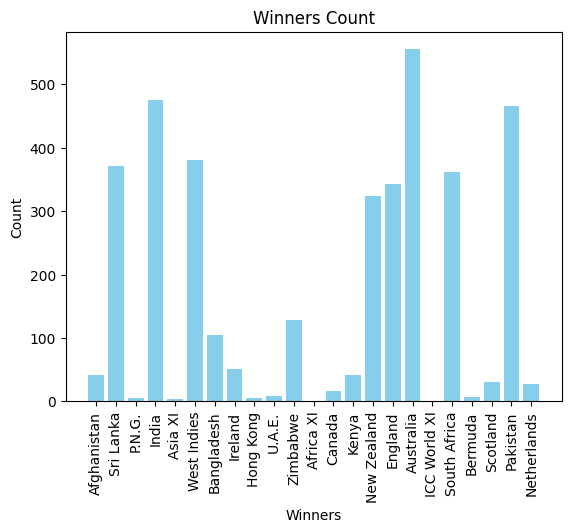

In [68]:
# Get the count of winning teams in an ODI dataset
winners = odi.groupBy("Winner").count().withColumnRenamed("count", "win count")

# Display the count of winners
# winners.show()

import matplotlib.pyplot as plt

# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = winners.toPandas()

# Create a bar chart using Matplotlib
# Set the x-axis as the "Winner" column and y-axis as the "win count" column
plt.bar(pandas_df["Winner"], pandas_df["win count"], color='skyblue')

# Label the x-axis as "Winners"
plt.xlabel("Winners")

# Label the y-axis as "Count"
plt.ylabel("Count")

# Set the title of the chart as "Winners Count"
plt.title("Winners Count")

# Rotate the x-axis labels vertically for better readability
plt.xticks(rotation='vertical')

# Display the chart
plt.show()

the team that has won the highest number of matches is **Australia**



---


Visualization of Pakistan's Match Results

---



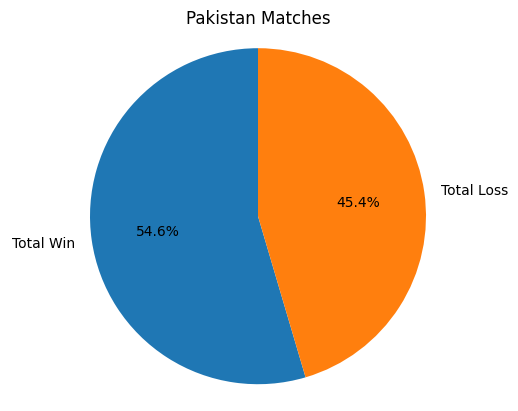

In [49]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Filter matches where Pakistan participated
Pakistan_matches = odi.filter(((col("Team 1") == 'Pakistan') | (col('Team 2') == 'Pakistan')))

# Count the total number of matches where Pakistan participated
Pakistan_total_matches = Pakistan_matches.count()

# Count the total number of matches won by Pakistan
Pakistan_wins = Pakistan_matches.filter(col("Winner") == "Pakistan").count()

# Calculate the win percentage of Pakistan
win_percentage = round((Pakistan_wins * 100) / Pakistan_total_matches, 2)

# Calculate the loss percentage of Pakistan
loss_percentage = 100 - win_percentage

# Create data for the pie chart
labels = ['Total Win', 'Total Loss']
sizes = [win_percentage, loss_percentage]

# Create the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

# Set the title of the chart as "Pakistan Matches"
plt.title('Pakistan Matches')

# Ensure the pie chart is drawn as a circle
plt.axis('equal')

# Display the pie chart
plt.show()



---
Visualization of Total ODI Teams Played Against Pakistan

---




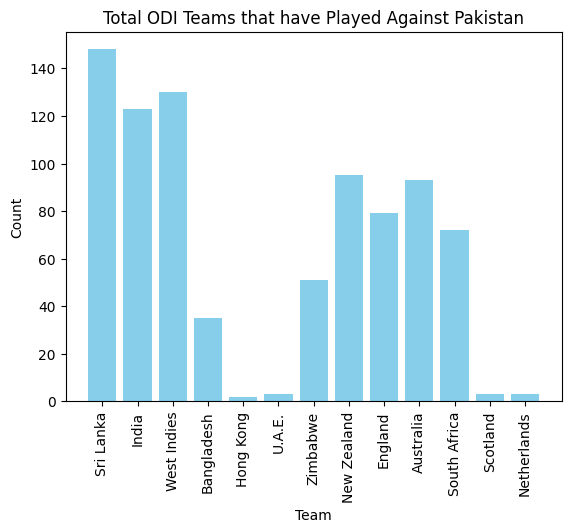

In [67]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Filter matches where Pakistan participated
against_pakistan = odi.filter((col('Team 1') == 'Pakistan') | (col('Team 2') == 'Pakistan'))

# Group matches by Team 1 and count occurrences
against_pakistan_team1 = against_pakistan.filter((col('Team 1') != 'Pakistan')).groupBy('Team 1').count().withColumnRenamed("Team 1", "Team").withColumnRenamed("count", "count1")

# Group matches by Team 2 and count occurrences
against_pakistan_team2 = against_pakistan.filter((col('Team 2') != 'Pakistan')).groupBy('Team 2').count().withColumnRenamed("Team 2", "Team").withColumnRenamed("count", "count2")

# Join the two dataframes to get the total count against Pakistan for each team
joined_against_pakistan = against_pakistan_team1.join(against_pakistan_team2, "Team")
against_pakistan_count = joined_against_pakistan.select(joined_against_pakistan['Team'], (col('count1')+col('count2'))).withColumnRenamed("(count1 + count2)", "count")

# Display the count of matches against Pakistan
# against_pakistan_count.show()

# Convert the DataFrame to a Pandas DataFrame
pandas_df = against_pakistan_count.toPandas()

# Create a bar chart using Matplotlib
plt.bar(pandas_df["Team"], pandas_df["count"],color='skyblue')
plt.xlabel("Team")
plt.ylabel("Count")
plt.title("Total ODI Teams that have Played Against Pakistan")
plt.xticks(rotation='vertical')
plt.show()



---

Visualization of the top 10 Grounds with the most matches played

---



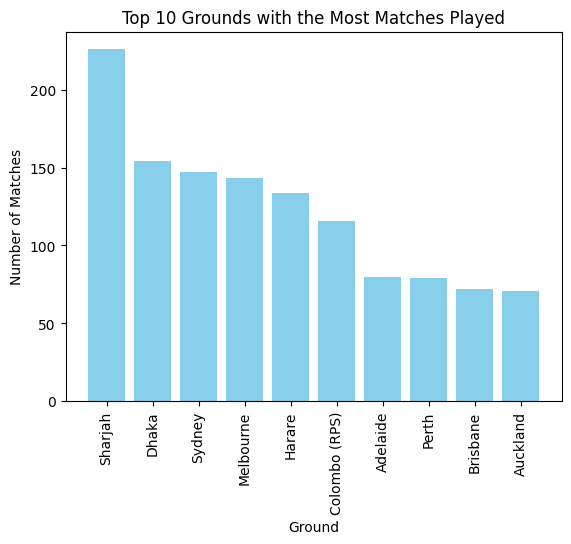

In [69]:
# Group the dataset by ground and count the matches played at each ground
matches_by_ground = odi.groupBy("Ground").count()

# Order the dataset
top_10_grounds = matches_by_ground.orderBy(col('count').desc()).limit(10)
#top_10_grounds.show()

# Convert the DataFrame to a Pandas DataFrame
pandas_df = top_10_grounds.toPandas()

# Create a bar chart using Matplotlib
plt.bar(pandas_df["Ground"], pandas_df["count"], color='skyblue')

# Set the labels and title
plt.xlabel("Ground")
plt.ylabel("Number of Matches")
plt.title("Top 10 Grounds with the Most Matches Played")

# Rotate the x-axis labels if needed for better readability
plt.xticks(rotation='vertical')

# Display the chart
plt.show()


the most frequently used cricket ground is '**Sharjah**'



---
Visualization of the teams' performance at different grounds


---




In [102]:
from pyspark.sql.functions import col, count, sum, when, round
import numpy as np

# Group the dataset by Team 1 and Ground, and calculate statistics
team1_performance = odi.groupBy("Team 1", "Ground").agg(
    count("Team 1").alias("MatchesPlayed1"),
    sum(when(col("Winner") == col("Team 1"), 1).otherwise(0)).alias("Wins1"),
    (sum(when(col("Winner") == col("Team 1"), 1).otherwise(0)) / count("Team 1")).alias("WinPercentage1")
).withColumnRenamed("Team 1", "Team")

# Group the dataset by Team 2 and Ground, and calculate statistics
team2_performance = odi.groupBy("Team 2", "Ground").agg(
    count("Team 2").alias("MatchesPlayed2"),
    sum(when(col("Winner") == col("Team 2"), 1).otherwise(0)).alias("Wins2")
).withColumnRenamed("Team 2", "Team")

# Join the two dataframes to get the total win, Matches played in the ground, and win pencentage for each team and ground
team_performance = team1_performance.join(team2_performance, ["Team", "Ground"])
team_performance_count = team_performance.select(team_performance['Team'], team_performance['Ground'], (col('MatchesPlayed1')+col('MatchesPlayed2')), (col('Wins1')+col('Wins2')))\
                            .withColumnRenamed("(Wins1 + Wins2)", "Wins")\
                            .withColumnRenamed("(MatchesPlayed1 + MatchesPlayed2)", "MatchesPlayed")


team_performance_count = team_performance_count\
                        .withColumn("WinPercentage", round((col("Wins") / col("MatchesPlayed")) * 100,2))

team_performance_count.show()


+------------+-------------+-------------+----+-------------+
|        Team|       Ground|MatchesPlayed|Wins|WinPercentage|
+------------+-------------+-------------+----+-------------+
|       Kenya|  Southampton|            2|   0|          0.0|
|   Australia|   Chandigarh|            2|   1|         50.0|
|   Australia|Colombo (SSC)|            6|   5|        83.33|
|    Pakistan|        Leeds|            7|   3|        42.86|
|  Bangladesh|   Bridgetown|            3|   0|          0.0|
|       India| Bloemfontein|            3|   1|        33.33|
|South Africa|   Wellington|            6|   3|         50.0|
|    Pakistan|Visakhapatnam|            2|   0|          0.0|
| New Zealand|  Mumbai (BS)|            3|   1|        33.33|
| New Zealand|        Dhaka|           13|   5|        38.46|
|South Africa|  Southampton|            3|   2|        66.67|
|     Bermuda|Nairobi (Gym)|            4|   0|          0.0|
|   Sri Lanka|      Sharjah|           78|  29|        37.18|
|       



---

Visualization of the number of matches played each year

---



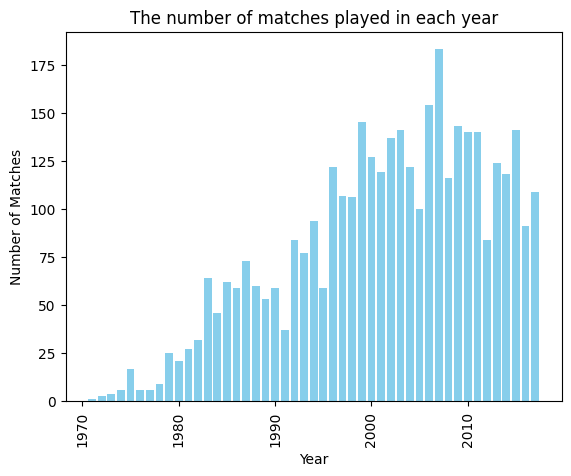

In [111]:
odi_year = odi.groupBy('year').count().orderBy(col('year').desc())
#odi_year.show()

# Convert the DataFrame to a Pandas DataFrame
pandas_df = odi_year.toPandas()

# Create a bar chart using Matplotlib
plt.bar(pandas_df["year"], pandas_df["count"], color='skyblue')

# Set the labels and title
plt.xlabel("Year")
plt.ylabel("Number of Matches")
plt.title("The number of matches played in each year")

# Rotate the x-axis labels if needed for better readability
plt.xticks(rotation='vertical')

# Display the chart
plt.show()